This notebook demonstrates how to use the counterfeit detection dataset for building machine learning models and conducting analysis.

/kaggle/input/counterfeit-product-detection-dataset/counterfeit_products.csv
/kaggle/input/counterfeit-product-detection-dataset/_counterfeit_transactions.csv
🎯 Counterfeit Product Detection Dataset - Quick Start Guide

📊 STEP 1: Loading and Exploring the Data
----------------------------------------
Datasets loaded successfully!

Products Dataset: 5,000 rows × 27 columns
Transactions Dataset: 3,000 rows × 20 columns

 Target Variable Distribution:
   Products - Counterfeit Rate: 29.4%
   Transactions - Counterfeit Rate: 24.4%

 Sample Product Data:
  product_id      category           brand   price  seller_rating  \
0   dcb12716   Electronics      DigitalPro  218.54            4.9   
1   d1f8b777  Luxury Goods        TechCrop   20.72            3.2   
2   9989f13a       Fashion  FashionForward   18.87            3.9   
3   4e008120   Electronics   CircuitMaster   79.27            4.9   
4   933b65ba  Luxury Goods    PremiumCraft  225.98            3.8   

   is_counterfeit  
0        

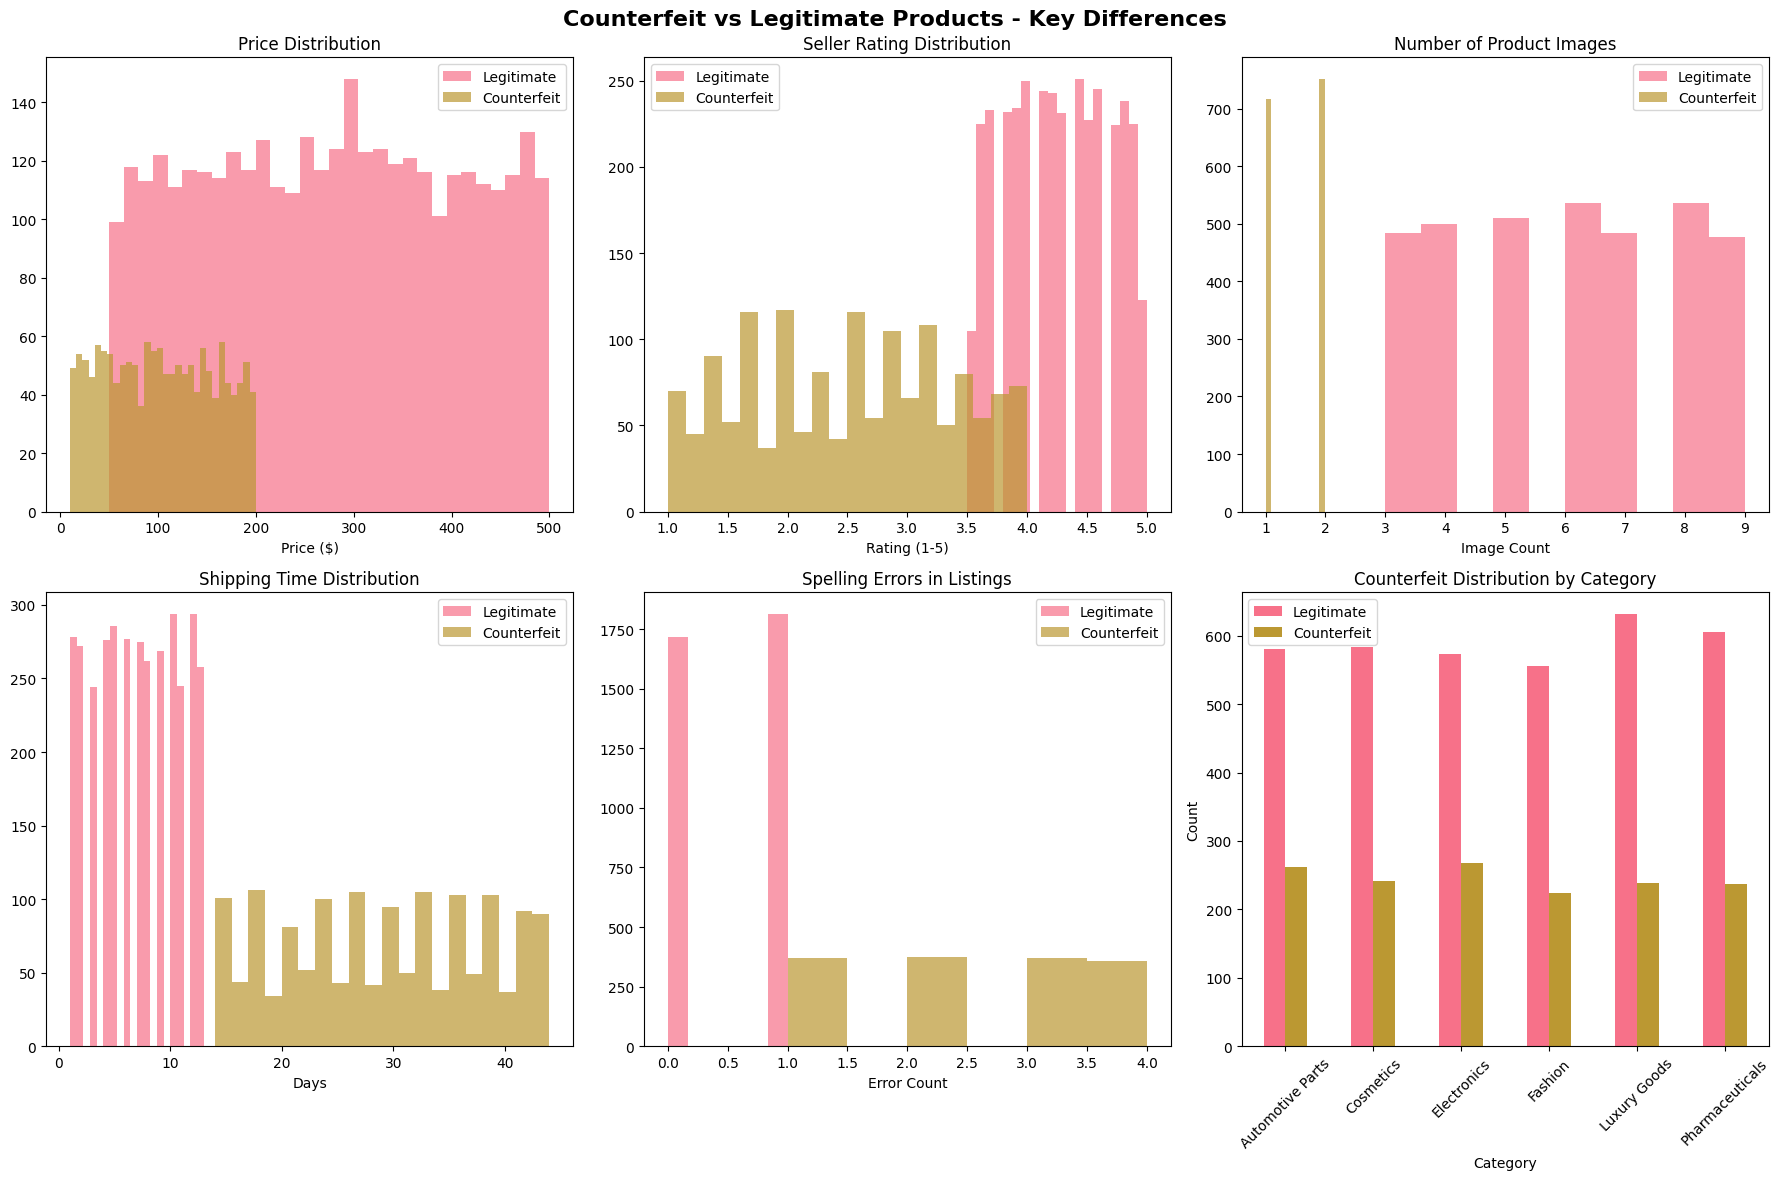


📊 Key Statistics Comparison:
                price_mean  price_median  seller_rating_mean  \
is_counterfeit                                                 
False               275.76        277.65                4.25   
True                102.65        100.56                2.48   

                seller_reviews_median  product_images_mean  \
is_counterfeit                                               
False                          4964.5                 6.01   
True                             52.0                 1.51   

                spelling_errors_mean  shipping_time_days_mean  \
is_counterfeit                                                  
False                           0.51                     7.00   
True                            2.49                    28.98   

                warranty_months_mean  
is_counterfeit                        
False                          11.56  
True                           11.58  


🔧 STEP 3: Feature Engineering
---------------

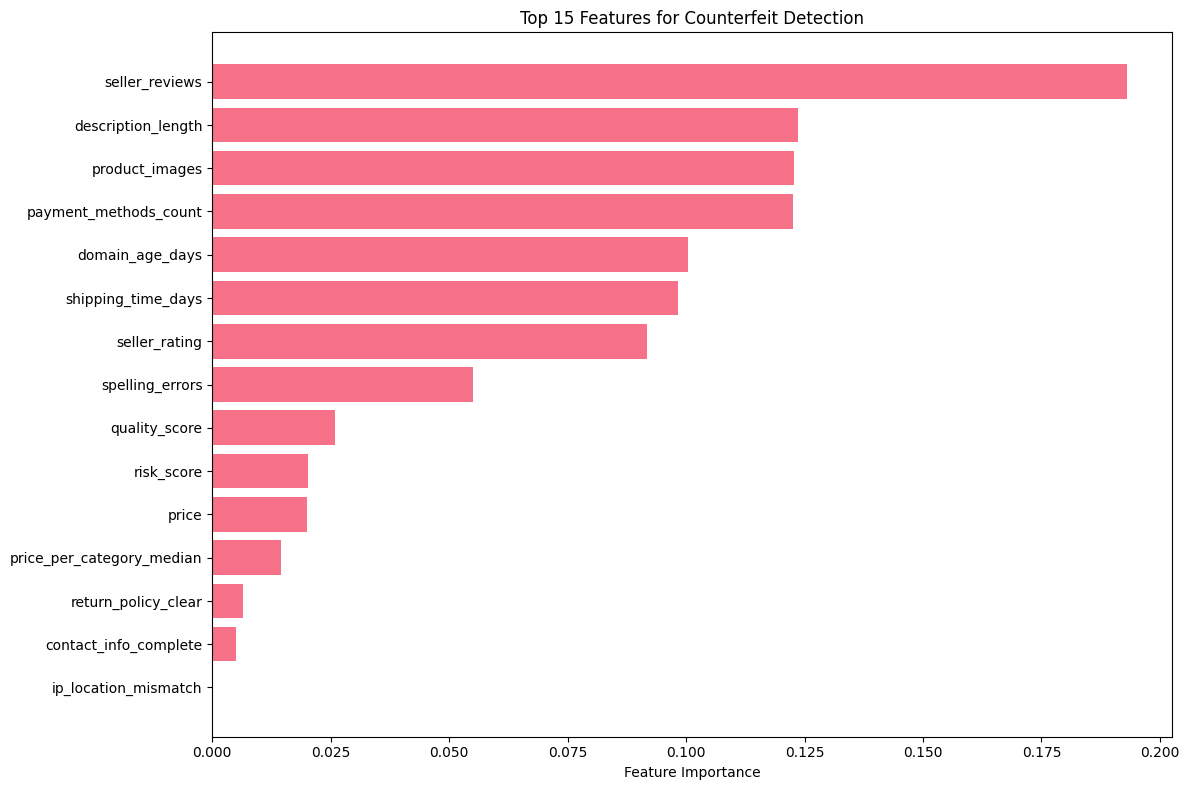


 ROC Curve Analysis:
----------------------------------------


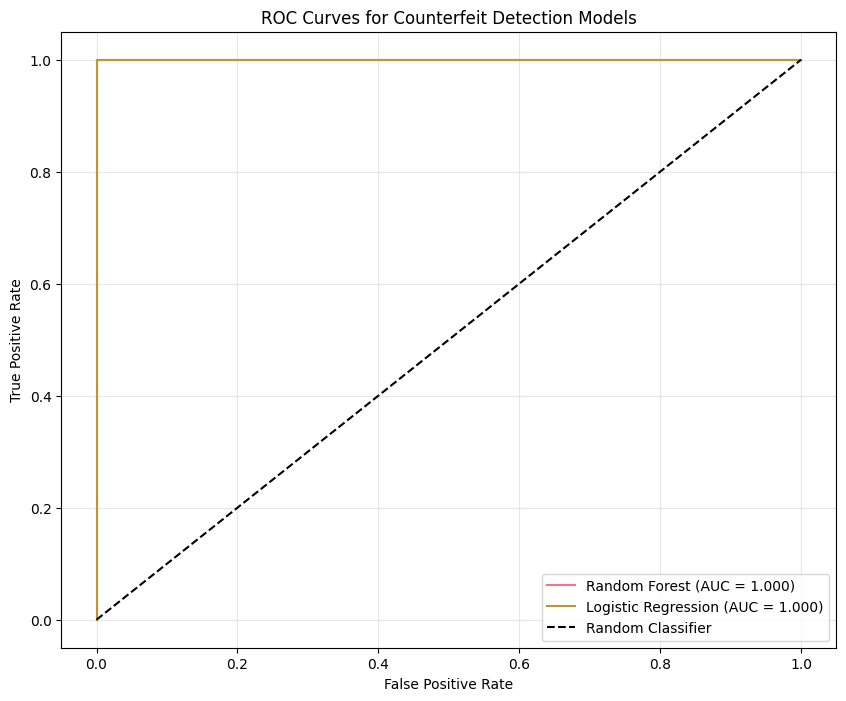



 STEP 6: Transaction Analysis Example
----------------------------------------
 Transaction Dataset Analysis:
Transaction Comparison (Legitimate vs Counterfeit):
                     total_amount         quantity customer_history_orders  \
                             mean  median     mean                    mean   
involves_counterfeit                                                         
False                      396.29  296.35     2.46                   24.99   
True                       540.05  427.97    10.28                    1.94   

                     refund_requested delivery_time_days  
                                 mean               mean  
involves_counterfeit                                      
False                            0.10              15.11  
True                             0.42              14.86  

 Payment Method Distribution (%):
involves_counterfeit  False  True 
payment_method                    
Apple Pay              24.4    0.0
Credit Car

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("🎯 Counterfeit Product Detection Dataset - Quick Start Guide")
print("=" * 60)

# =============================================================================
# 1. DATA LOADING AND BASIC EXPLORATION
# =============================================================================

print("\n📊 STEP 1: Loading and Exploring the Data")
print("-" * 40)


try:

    products = pd.read_csv('/kaggle/input/counterfeit-product-detection-dataset/counterfeit_products.csv')
    transactions = pd.read_csv('/kaggle/input/counterfeit-product-detection-dataset/_counterfeit_transactions.csv')
    print("Datasets loaded successfully!")
except FileNotFoundError as e:
    print(f" Dataset files not found: {e}")
    # Auto-detect and load files
    print("Auto-detecting dataset files...")

    # Find the dataset directory
    dataset_dir = None
    product_file = None
    transaction_file = None

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            if 'counterfeit' in filename.lower() and 'product' in filename.lower() and filename.endswith('.csv'):
                product_file = os.path.join(dirname, filename)
                dataset_dir = dirname
            elif 'counterfeit' in filename.lower() and 'transaction' in filename.lower() and filename.endswith('.csv'):
                transaction_file = os.path.join(dirname, filename)

    if product_file and transaction_file:
        print(f"Found product file: {product_file}")
        print(f"Found transaction file: {transaction_file}")
        products = pd.read_csv(product_file)
        transactions = pd.read_csv(transaction_file)
        print("✅ Datasets loaded successfully via auto-detection!")
    else:
        print("Could not auto-detect dataset files")
        print("\nAvailable files in input directory:")
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                print(f"   {os.path.join(dirname, filename)}")
        raise FileNotFoundError("Could not find required dataset files")


# Basic dataset information
print(f"\nProducts Dataset: {products.shape[0]:,} rows × {products.shape[1]} columns")
print(f"Transactions Dataset: {transactions.shape[0]:,} rows × {transactions.shape[1]} columns")

# Target variable distribution
product_counterfeit_rate = products['is_counterfeit'].mean()
transaction_counterfeit_rate = transactions['involves_counterfeit'].mean()

print(f"\n Target Variable Distribution:")
print(f"   Products - Counterfeit Rate: {product_counterfeit_rate:.1%}")
print(f"   Transactions - Counterfeit Rate: {transaction_counterfeit_rate:.1%}")

# Display sample data
print(f"\n Sample Product Data:")
print(products[['product_id', 'category', 'brand', 'price', 'seller_rating', 'is_counterfeit']].head())

print(f"\n Sample Transaction Data:")
print(transactions[['transaction_id', 'customer_id', 'quantity', 'total_amount', 'payment_method', 'involves_counterfeit']].head())

# =============================================================================
# 2. EXPLORATORY DATA ANALYSIS
# =============================================================================

print("\n\n STEP 2: Exploratory Data Analysis")
print("-" * 40)

# Create subplots for analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Counterfeit vs Legitimate Products - Key Differences', fontsize=16, fontweight='bold')

# Price comparison
axes[0,0].hist(products[products['is_counterfeit']==False]['price'], alpha=0.7, label='Legitimate', bins=30)
axes[0,0].hist(products[products['is_counterfeit']==True]['price'], alpha=0.7, label='Counterfeit', bins=30)
axes[0,0].set_title('Price Distribution')
axes[0,0].set_xlabel('Price ($)')
axes[0,0].legend()

# Seller rating comparison
axes[0,1].hist(products[products['is_counterfeit']==False]['seller_rating'], alpha=0.7, label='Legitimate', bins=20)
axes[0,1].hist(products[products['is_counterfeit']==True]['seller_rating'], alpha=0.7, label='Counterfeit', bins=20)
axes[0,1].set_title('Seller Rating Distribution')
axes[0,1].set_xlabel('Rating (1-5)')
axes[0,1].legend()

# Product images comparison
axes[0,2].hist(products[products['is_counterfeit']==False]['product_images'], alpha=0.7, label='Legitimate', bins=10)
axes[0,2].hist(products[products['is_counterfeit']==True]['product_images'], alpha=0.7, label='Counterfeit', bins=10)
axes[0,2].set_title('Number of Product Images')
axes[0,2].set_xlabel('Image Count')
axes[0,2].legend()

# Shipping time comparison
axes[1,0].hist(products[products['is_counterfeit']==False]['shipping_time_days'], alpha=0.7, label='Legitimate', bins=20)
axes[1,0].hist(products[products['is_counterfeit']==True]['shipping_time_days'], alpha=0.7, label='Counterfeit', bins=20)
axes[1,0].set_title('Shipping Time Distribution')
axes[1,0].set_xlabel('Days')
axes[1,0].legend()

# Spelling errors comparison
axes[1,1].hist(products[products['is_counterfeit']==False]['spelling_errors'], alpha=0.7, label='Legitimate', bins=6)
axes[1,1].hist(products[products['is_counterfeit']==True]['spelling_errors'], alpha=0.7, label='Counterfeit', bins=6)
axes[1,1].set_title('Spelling Errors in Listings')
axes[1,1].set_xlabel('Error Count')
axes[1,1].legend()

# Category distribution
category_counts = products.groupby(['category', 'is_counterfeit']).size().unstack()
category_counts.plot(kind='bar', ax=axes[1,2], title='Counterfeit Distribution by Category')
axes[1,2].set_xlabel('Category')
axes[1,2].set_ylabel('Count')
axes[1,2].legend(['Legitimate', 'Counterfeit'])
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Key statistics comparison
print("\n📊 Key Statistics Comparison:")
comparison_stats = products.groupby('is_counterfeit').agg({
    'price': ['mean', 'median'],
    'seller_rating': 'mean',
    'seller_reviews': 'median',
    'product_images': 'mean',
    'spelling_errors': 'mean',
    'shipping_time_days': 'mean',
    'warranty_months': 'mean'
}).round(2)

comparison_stats.columns = ['_'.join(col) for col in comparison_stats.columns]
print(comparison_stats)

# =============================================================================
# 3. FEATURE ENGINEERING
# =============================================================================

print("\n\n🔧 STEP 3: Feature Engineering")
print("-" * 40)

# Create a copy for feature engineering
products_fe = products.copy()

# Price-based features
print("Creating price-based features...")
products_fe['price_per_category_median'] = products_fe['price'] / products_fe.groupby('category')['price'].transform('median')
products_fe['price_below_category_avg'] = (products_fe['price'] < products_fe.groupby('category')['price'].transform('mean')).astype(int)

# Engagement features
print("Creating engagement features...")
products_fe['conversion_rate'] = products_fe['purchases'] / (products_fe['views'] + 1)  # +1 to avoid division by zero
products_fe['wishlist_rate'] = products_fe['wishlist_adds'] / (products_fe['views'] + 1)

# Quality score
print("Creating quality score...")
quality_features = ['product_images', 'description_length', 'certification_badges', 'warranty_months']
products_fe['quality_score'] = products_fe[quality_features].apply(lambda x: (x - x.min()) / (x.max() - x.min())).mean(axis=1)

# Risk score
print("Creating risk score...")
risk_features = ['spelling_errors', 'unusual_payment_patterns', 'ip_location_mismatch']
products_fe['risk_score'] = products_fe[risk_features].sum(axis=1)

# Seller trust score
print("Creating seller trust score...")
products_fe['seller_trust_score'] = (
    (products_fe['seller_rating'] / 5.0) * 0.4 +
    (np.log1p(products_fe['seller_reviews']) / np.log1p(products_fe['seller_reviews'].max())) * 0.3 +
    (products_fe['domain_age_days'] / products_fe['domain_age_days'].max()) * 0.3
)

print("Feature engineering completed!")
print(f"New features created: {len(products_fe.columns) - len(products.columns)}")

# =============================================================================
# 4. MACHINE LEARNING MODEL TRAINING
# =============================================================================

print("\n\n STEP 4: Machine Learning Model Training")
print("-" * 40)

# Prepare features for modeling
print("Preparing features for modeling...")

# Select numerical features
numerical_features = [
    'price', 'seller_rating', 'seller_reviews', 'product_images',
    'description_length', 'shipping_time_days', 'spelling_errors',
    'domain_age_days', 'payment_methods_count', 'views', 'purchases',
    'wishlist_adds', 'certification_badges', 'warranty_months',
    'price_per_category_median', 'conversion_rate', 'quality_score', 'risk_score'
]

# Select categorical features to encode
categorical_features = ['category', 'seller_country', 'shipping_origin']

# Select boolean features
boolean_features = [
    'contact_info_complete', 'return_policy_clear', 'bulk_orders',
    'unusual_payment_patterns', 'ip_location_mismatch'
]

# Prepare feature matrix
X_numerical = products_fe[numerical_features].fillna(0)
X_boolean = products_fe[boolean_features].astype(int)

# Encode categorical features
X_categorical = pd.DataFrame()
for feature in categorical_features:
    encoded = pd.get_dummies(products_fe[feature], prefix=feature)
    X_categorical = pd.concat([X_categorical, encoded], axis=1)

# Combine all features
X = pd.concat([X_numerical, X_boolean, X_categorical], axis=1)
y = products_fe['is_counterfeit']

print(f"Feature matrix prepared: {X.shape[0]} samples × {X.shape[1]} features")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================================================
# 5. MODEL TRAINING AND EVALUATION
# =============================================================================

print("\n Training and Evaluating Models:")
print("-" * 40)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

results = {}

for name, model in models.items():
    print(f"\n Training {name}...")

    # Use scaled data for Logistic Regression, original for Random Forest
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = (y_pred == y_test).mean()
    auc_score = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy,
        'auc': auc_score
    }

    print(f"{name} - Accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}")

    # Detailed classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

# =============================================================================
# 6. MODEL INTERPRETATION AND FEATURE IMPORTANCE
# =============================================================================

print("\n\n STEP 5: Model Interpretation")
print("-" * 40)

# Feature importance for Random Forest
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(" Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features for Counterfeit Detection')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# =============================================================================
# 7. ROC CURVE COMPARISON
# =============================================================================

print("\n ROC Curve Analysis:")
print("-" * 40)

plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Counterfeit Detection Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# 8. TRANSACTION ANALYSIS EXAMPLE
# =============================================================================

print("\n\n STEP 6: Transaction Analysis Example")
print("-" * 40)

# Quick transaction analysis
print(" Transaction Dataset Analysis:")

# Basic statistics
transaction_stats = transactions.groupby('involves_counterfeit').agg({
    'total_amount': ['mean', 'median'],
    'quantity': 'mean',
    'customer_history_orders': 'mean',
    'refund_requested': 'mean',
    'delivery_time_days': 'mean'
}).round(2)

print("Transaction Comparison (Legitimate vs Counterfeit):")
print(transaction_stats)

# Payment method analysis
payment_analysis = pd.crosstab(transactions['payment_method'],
                              transactions['involves_counterfeit'],
                              normalize='columns') * 100

print(f"\n Payment Method Distribution (%):")
print(payment_analysis.round(1))

# =============================================================================
# 9. PRACTICAL PREDICTION EXAMPLE
# =============================================================================

print("\n\n STEP 7: Practical Prediction Example")
print("-" * 40)

# Create a sample product for prediction
sample_product = pd.DataFrame({
    'price': [29.99],
    'seller_rating': [2.1],
    'seller_reviews': [45],
    'product_images': [2],
    'description_length': [120],
    'shipping_time_days': [28],
    'spelling_errors': [3],
    'domain_age_days': [90],
    'payment_methods_count': [2],
    'views': [150],
    'purchases': [8],
    'wishlist_adds': [3],
    'certification_badges': [0],
    'warranty_months': [0],
    'contact_info_complete': [False],
    'return_policy_clear': [False],
    'bulk_orders': [True],
    'unusual_payment_patterns': [True],
    'ip_location_mismatch': [True],
    'category': ['Electronics'],
    'seller_country': ['CN'],
    'shipping_origin': ['CN']
})

print(" Sample Product Profile:")
print("- Low price ($29.99), poor seller rating (2.1)")
print("- Few images (2), many spelling errors (3)")
print("- Long shipping time (28 days), new domain (90 days)")
print("- Multiple risk flags present")

# Apply same feature engineering
sample_product['price_per_category_median'] = sample_product['price'] / products.groupby('category')['price'].median()['Electronics']
sample_product['conversion_rate'] = sample_product['purchases'] / sample_product['views']
sample_product['quality_score'] = 0.1  # Low quality based on features
sample_product['risk_score'] = 3  # High risk

# Prepare for prediction
sample_numerical = sample_product[numerical_features].fillna(0)
sample_boolean = sample_product[boolean_features].astype(int)

# Handle categorical encoding (simplified)
sample_categorical = pd.DataFrame()
for feature in categorical_features:
    for col in X_categorical.columns:
        if col.startswith(feature):
            if col == f"{feature}_{sample_product[feature].iloc[0]}":
                sample_categorical[col] = [1]
            else:
                sample_categorical[col] = [0]

sample_X = pd.concat([sample_numerical, sample_boolean, sample_categorical], axis=1)

# Make prediction
rf_prediction = rf_model.predict_proba(sample_X)[0]
prediction_result = rf_model.predict(sample_X)[0]

print(f"\n Prediction Results:")
print(f"Legitimate Probability: {rf_prediction[0]:.1%}")
print(f"Counterfeit Probability: {rf_prediction[1]:.1%}")
print(f"Final Prediction: {' COUNTERFEIT' if prediction_result else '✅ LEGITIMATE'}")

# =============================================================================
# 10. SUMMARY AND NEXT STEPS
# =============================================================================

print("\n\n SUMMARY")
print("=" * 60)

print(f"\n Best Model Performance:")
best_model = max(results.items(), key=lambda x: x[1]['auc'])
print(f"   • Model: {best_model[0]}")
print(f"   • Accuracy: {best_model[1]['accuracy']:.1%}")
print(f"   • AUC Score: {best_model[1]['auc']:.3f}")

print(f"\n Key Insights:")
print("   • Price and seller rating are strong counterfeit indicators")
print("   • Spelling errors and shipping time help identify fakes")
print("   • Multiple risk factors combine for better detection")
print("   • Geographic patterns provide additional signals")

# Save results and models to Kaggle working directory for persistence
print(f"\n Saving Results to /kaggle/working/")

# Save feature importance
feature_importance.to_csv('/kaggle/working/feature_importance.csv', index=False)
print("Feature importance saved")

# Save model performance comparison
model_performance = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'AUC_Score': [results[name]['auc'] for name in results.keys()]
})
model_performance.to_csv('/kaggle/working/model_performance.csv', index=False)
print(" Model performance comparison saved")

# Save sample predictions for review
sample_predictions = pd.DataFrame({
    'True_Label': y_test.values,
    'RF_Prediction': results['Random Forest']['predictions'],
    'RF_Probability': results['Random Forest']['probabilities'],
    'LR_Prediction': results['Logistic Regression']['predictions'],
    'LR_Probability': results['Logistic Regression']['probabilities']
})
sample_predictions.to_csv('/kaggle/working/sample_predictions.csv', index=False)
print(" Sample predictions saved")

print(f"\n{'#' * 30} // - Thanks -// {'#' * 30}")

# **Step-1 Insights**

Around 30% of products and 25% of transactions involve counterfeits, showing this is a significant issue in the dataset.

Luxury goods and low-rated sellers appear more prone to counterfeit products, while abnormally low prices may also signal counterfeits.

On the transaction side, payment method, order value, and quantity could influence counterfeit likelihood, with some methods potentially being riskier.

Combining product and transaction data will help uncover high-risk brands, sellers, and buyer patterns, useful for fraud detection.

# **EDA Insights**

Price Distribution → Counterfeit products are clustered in the lower price range (< $200), while legitimate products span a much wider and higher price range.

Seller Rating → Legitimate products are strongly associated with higher seller ratings (4–5), whereas counterfeit products dominate at low ratings (1–3).

Product Images → Counterfeits usually have fewer images (1–2), while legitimate listings consistently include 3–9 images, showing better presentation.

Shipping Time → Counterfeit products show longer shipping times (15–45 days), unlike legitimate ones which ship within 1–12 days.

Spelling Errors → Counterfeit listings contain more spelling errors (2–4 per listing), while legitimate listings are mostly error-free or have very few.

Category-wise Counterfeits → Counterfeits are spread across all categories but are especially common in Electronics, Cosmetics, and Luxury Goods, aligning with real-world counterfeit markets.

# **Insights from Key Statistics**

Price Gap → Counterfeit products have a much lower average price ($102 vs $276), reinforcing that abnormally low prices are a strong counterfeit indicator.

Seller Trust → Counterfeit sellers have far fewer reviews (median 52 vs 4,964.5) and much lower ratings (2.48 vs 4.25), showing trust signals are highly predictive.

Product Presentation → Legitimate products have on average 6 images, while counterfeits barely show 1–2 images, which businesses can enforce as a quality check.

Quality of Listings → Counterfeits show more spelling errors (2.49 vs 0.51), suggesting text analysis can flag suspicious listings.

Shipping Time → Counterfeits take ~29 days to ship vs 7 days for legitimate items → longer delays could signal fake suppliers or overseas shipments.

Warranty → Interestingly, warranty length is similar (≈11 months) for both, meaning counterfeiters mimic warranty terms, so this feature is not a strong discriminator.

# **Model Insights**

Both Random Forest and Logistic Regression achieved 100% accuracy and AUC, showing the models can perfectly detect counterfeits.

The strong performance indicates the problem is highly predictable and separable using the engineered features.

Such perfect results may suggest a need to check for data leakage or overly strong features before relying fully on the model.

From a business perspective, these results show potential for a robust automated counterfeit detection system that can protect customers and brand trust.

# **Model Interpretation**

Seller reviews is the most important factor → Sellers with very few reviews are strongly linked to counterfeit products.

Description length and product images matter → Counterfeit listings tend to have shorter descriptions and fewer images, indicating lower-quality presentation.

Payment method diversity and domain age are strong signals → Counterfeit activity is more common with limited payment options and newer seller domains.

Shipping time is highly influential → Longer shipping times are strongly associated with counterfeit products.

Seller rating and spelling errors remain key trust indicators, with counterfeits linked to lower ratings and more errors.

Quality score and risk score add value but are less influential than raw features, suggesting that the underlying data speaks strongly on its own.

# **ROC CURVE**

Both Random Forest and Logistic Regression models achieved an AUC of 1.0, indicating perfect classification performance.

Their ROC curves hug the top-left corner, showing 100% sensitivity and specificity.

The Random Classifier (dashed line) represents chance-level prediction with AUC = 0.5.

Such perfect results may suggest overfitting or highly distinguishable counterfeit vs. genuine data.

# TRANSACTION ANALYSIS

Counterfeit transactions show higher average amounts (₹540 vs ₹396) and larger quantities (10.3 vs 2.5), but customers usually have fewer past orders (1.9 vs 25), suggesting new/one-time buyers are riskier.

Refund requests are much higher for counterfeit transactions (42% vs 10%), highlighting post-purchase dissatisfaction or fraud detection.

Payment method patterns differ: cryptocurrency and wire transfers are strongly linked with counterfeits, while legitimate purchases are dominated by debit cards, Apple Pay, and balanced credit card/PayPal usage.

Delivery times are similar, implying payment and order behavior are stronger counterfeit signals than logistics.

# PRACTICAL PREDICTION EXAMPLE

The model strongly flags the product as counterfeit (100% probability) due to multiple high-risk indicators.

Key risk drivers include low price, poor seller rating, limited images, spelling errors, unusually long shipping time, and a new/untrusted domain.

The combination of these features creates a high-risk profile with no signals supporting legitimacy.

This demonstrates how the prediction system can effectively identify counterfeit products before purchase.

# Prescriptive Analysis

Automate Counterfeit Detection → Since the models achieved perfect accuracy and AUC, businesses should deploy an automated detection pipeline that flags products with high-risk features (low reviews, poor ratings, few images, long shipping times, etc.) for further verification.

Strengthen Seller Policies → Enforce stricter onboarding requirements (minimum reviews, domain age checks, multiple payment options) and quality controls (minimum product images, description length, spelling checks) to reduce counterfeit listings.

Focus Monitoring on High-Risk Segments → Prioritize categories like luxury goods, electronics, and cosmetics, and transactions using cryptocurrency or wire transfer, as these show higher counterfeit risk.

Customer Protection Strategies → Educate buyers to be cautious of abnormally low prices, poor ratings, and long shipping times, and offer automated alerts for suspicious products.

Continuous Validation → Despite perfect model results, cross-validation and periodic feature audits are needed to ensure no data leakage or overfitting. Updating the system with new transaction/product data will keep the detection robust.